In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
images, labels = skds.fetch_openml("mnist_784", return_X_y=True)
X=images
X = StandardScaler().fit_transform(X)
labels[labels=='4']=0
labels[labels=='6']=0
labels[labels=='8']=0
labels[labels=='9']=0
labels[labels=='0']=0
labels[labels=='2']=1
labels[labels=='3']=1
labels[labels=='5']=1
labels[labels=='7']=1
labels[labels=='1']=1

In [7]:
x_neg=X[labels==0]
x_pos=X[labels==1]

In [8]:
np.random.shuffle(x_neg)
x_test=x_neg[0:17193]
x_train=x_neg[17193:34386]
x_train=np.concatenate((x_train,x_pos))
y_train=np.concatenate((np.zeros(17193),np.ones(35614)))
y_test=np.zeros(17193)

# Standard Bloom Filter

In [9]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [10]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [11]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [12]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [13]:
num_of_iterations = 3#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5350,5350,20,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(35614, 784)
Size: 5350 Bits - FPR: 0.948758 - Time Taken to create Standard: 3.714319 - Time Taken to create Projecion: 36.980987 



Size: 10700 Bits - FPR: 0.892689 - Time Taken to create Standard: 7.289946 - Time Taken to create Projecion: 22.489391 



Size: 16050 Bits - FPR: 0.846100 - Time Taken to create Standard: 3.346391 - Time Taken to create Projecion: 28.401670 



Size: 21400 Bits - FPR: 0.776304 - Time Taken to create Standard: 4.016492 - Time Taken to create Projecion: 20.458116 



Size: 26750 Bits - FPR: 0.714186 - Time Taken to create Standard: 3.771056 - Time Taken to create Projecion: 21.176461 



Size: 32100 Bits - FPR: 0.683708 - Time Taken to create Standard: 3.777785 - Time Taken to create Projecion: 27.669856 



Size: 37450 Bits - FPR: 0.569476 - Time Taken to create Standard: 3.728012 - Time Taken to create Projecion: 16.695316 



Size: 42800 Bits - FPR: 0.573664 - Time Taken to create Standard: 3.820788 - Time Taken to crea

In [14]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

20


In [15]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

20


In [16]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

20


# Normal Bloom Filter Values

In [17]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [18]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

60
35614.0


# FPR Comparison between Projection Model and Normal Bloom Filter

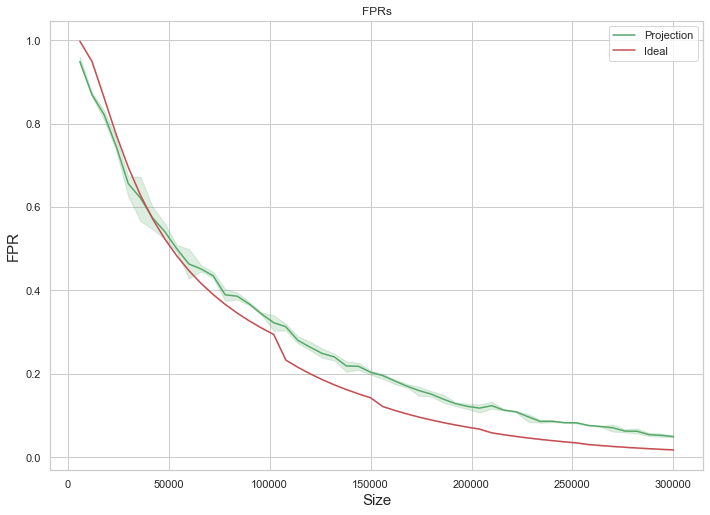

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [17]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

150


In [18]:
average_times = num_of_iterations*average_times
print(len(average_times))

150


In [19]:
print(average_fprs)

[0.948506174993699, 0.8691133988638787, 0.8213032435681189, 0.7452257701777856, 0.655790147152911, 0.6214738556389229, 0.5740126795788983, 0.5414025087729503, 0.5000096938676593, 0.4634056495860719, 0.4516179065123403, 0.4352546579034103, 0.3896159289633378, 0.3861455243413017, 0.3672230946703115, 0.3435506698462552, 0.3228251807906319, 0.3129955989840827, 0.2803660404428159, 0.2642742201283468, 0.24911301110917236, 0.24073750945152095, 0.21908140910060295, 0.2182283487465829, 0.2039783632873844, 0.19602939180674306, 0.18290389499602552, 0.17074778495123985, 0.16002636732003336, 0.1516702533977006, 0.1395916942941895, 0.12881211345702706, 0.12210395703677852, 0.11811008356113924, 0.12386824095077453, 0.11326314973147987, 0.10926927625584056, 0.09734581903487853, 0.086197871226662, 0.08646929952112294, 0.08323154772291048, 0.0828244052812191, 0.07648461583202466, 0.07408053665251363, 0.07086217258961981, 0.06297136431493437, 0.062564221873243, 0.05446014851005254, 0.052734640066693816, 

In [19]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,5350,0.998716,3.714319,4.260118,0.948758,0.951628,36.980987,27.159581
1,10700,0.964156,7.289946,6.294314,0.892689,0.893542,22.489391,20.423535
2,16050,0.891283,3.346391,3.710928,0.846100,0.844220,28.401670,22.839478
3,21400,0.810666,4.016492,4.252719,0.776304,0.768918,20.458116,20.744414
4,26750,0.735890,3.771056,3.287937,0.714186,0.723996,21.176461,17.211276


In [20]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/MNIST_rerun_epochs_100.csv')